In [1]:
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from classifiers.quantum.qasvm import QASVM

from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel

from qiskit.providers.aer import AerSimulator
from qiskit.providers.ibmq import IBMQ
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt

In [2]:
if not IBMQ.active_account():
    IBMQ.load_account()
provider = IBMQ.providers()[1]
backend = provider.get_backend('ibmq_casablanca')

In [3]:
MAXITER = 2**6
LAST_AVG = 2**4
TEST_SIZE = 16

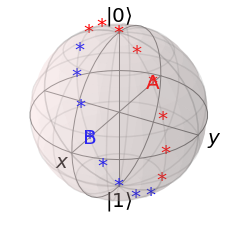

In [4]:
X = np.array([[np.pi/4, np.pi/3], [np.pi*5/4, np.pi/3]])
y=np.array([0, 1])
ax = plt.axes(projection='3d')

from qiskit.visualization.bloch import Bloch
B = Bloch(axes=ax)

def s2c(x):
    bloch = [1, x[0], x[1]]
    r, theta, phi = bloch[0], bloch[1], bloch[2]
    bloch[0] = r * np.sin(theta) * np.cos(phi)
    bloch[1] = r * np.sin(theta) * np.sin(phi)
    bloch[2] = r * np.cos(theta)
    return bloch

def c2s(bloch):
    x = [np.arccos(bloch[2]), np.arctan(bloch[1]/bloch[0])]
    return x

vecs = np.array(list(map(s2c, X)))
for v in vecs[y==0]:
    B.add_annotation(v, text='A', color='r')
for v in vecs[y==1]:
    B.add_annotation(v, text='B', color='b')
# B.add_annotation(vecs.mean(axis=0), text='M', color='k')
vecA = vecs[y==0].mean(axis=0)
vecA = vecA/np.linalg.norm(vecA)
vecB = vecs[y==1].mean(axis=0)
vecB = vecB/np.linalg.norm(vecB)
vecP = (vecA-vecB)/np.linalg.norm(vecA-vecB)
vecQ = -(vecA-vecB)/np.linalg.norm(vecA-vecB)
#B.add_annotation(vecP, text='P', color='r')
#B.add_annotation(vecQ, text='Q', color='b')

def test_data_gen(n, vecP, vecQ):
    Xt = np.array([np.linspace(0, 2*np.pi, n+1), c2s(vecP)[1]*np.ones(n+1)]).T
    Xt = Xt[1:]
    yt = np.where(np.dot(np.array(list(map(s2c, Xt))), vecP-vecQ)<0, 1, 0)
    return Xt, yt

Xt, yt = test_data_gen(TEST_SIZE, vecP, vecQ)

vecs = np.array(list(map(s2c, Xt)))
for v in vecs[yt==0]:
    B.add_annotation(v, text='*', color='r')
for v in vecs[yt==1]:
    B.add_annotation(v, text='*', color='b')

B.render()

In [5]:
svm = BinarySVM(Kernel('SingleQubit', reps=1), mutation='REDUCED_QASVM', C=None, k=10)
svm.fit(X, y)
Xtt, ytt = test_data_gen(100, vecP, vecQ)
svm_fvec = svm.f(Xtt)

41
41


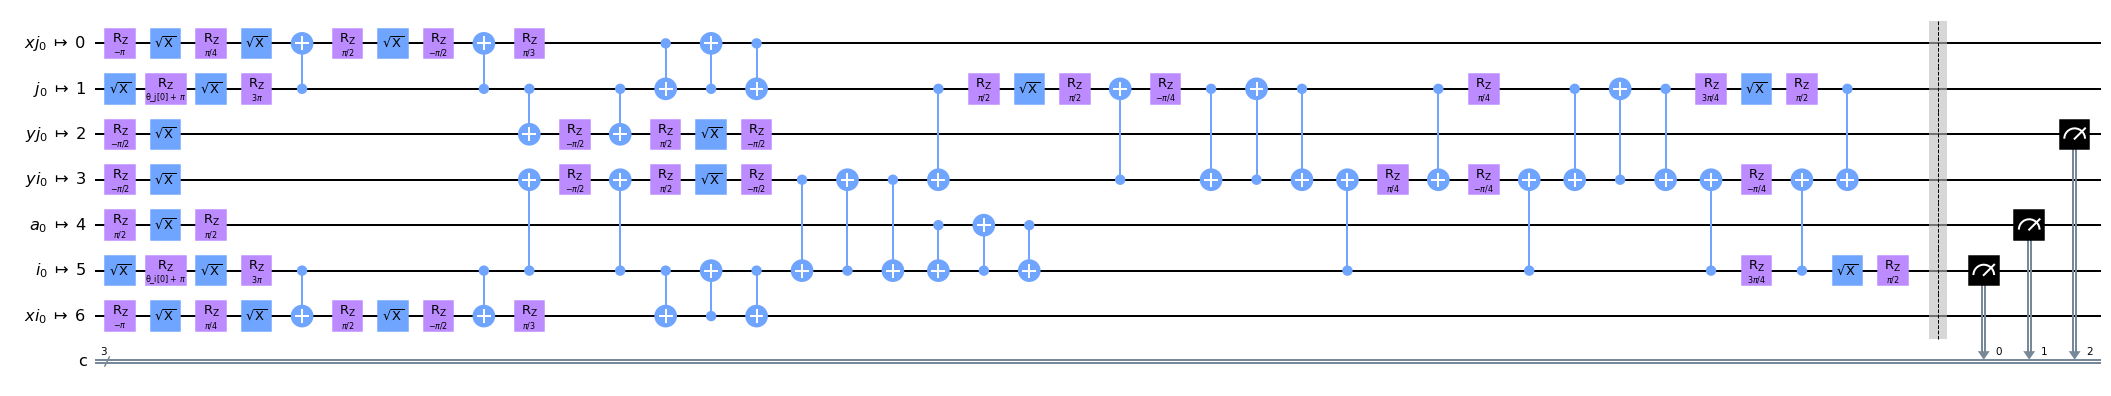

In [6]:
var_form = RealAmplitudes(1, reps=1, skip_final_rotation_layer=True)
quantum_instance = QuantumInstance(backend, shots=2**13, optimization_level=2, measurement_error_mitigation_cls=CompleteMeasFitter)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

In [7]:
import qiskit.tools.jupyter
%qiskit_job_watcher

storage = CostParamStorage()
optimizer = tSPSA(maxiter=MAXITER, blocking=True, last_avg=LAST_AVG, callback=storage)
si_quantum_instance = QuantumInstance(AerSimulator.from_backend(backend), shots=2**13, optimization_level=2, measurement_error_mitigation_cls=CompleteMeasFitter)

#qasvm._quantum_instance = si_quantum_instance

for epoch in tqdm(range(1, MAXITER + 1)):
    optimizer.step(qasvm.cost_fn, qasvm.parameters)
    #if epoch == 2 * LAST_AVG:
    #    qasvm._quantum_instance = quantum_instance
    if storage.num_accepted() > 2 * LAST_AVG and storage.last_cost_avg(2 * LAST_AVG, ignore_rejected=True) < storage.last_cost_avg(LAST_AVG, ignore_rejected=True):
        break


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

  0%|          | 0/64 [00:00<?, ?it/s]

(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
/home/quic/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:695: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.


In [8]:
import qiskit.tools.jupyter
%qiskit_job_watcher
qasvm.parameters = storage.last_avg(LAST_AVG, ignore_rejected=False)
fvec = qasvm.f(Xt)
if len(fvec)!=len(yt):
    fvec = fvec[4:]

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Text(0, 0.5, 'classification score')

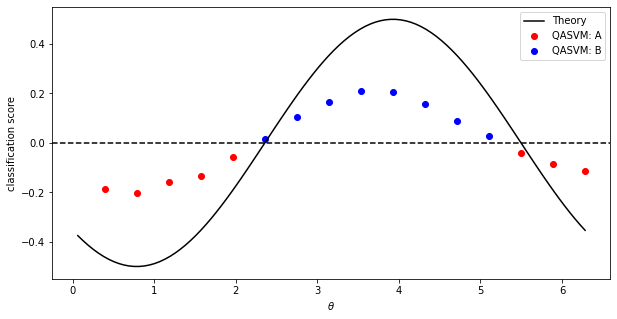

In [12]:
St = Xt[:, 0]
Stt = Xtt[:, 0]
plt.figure(figsize=(10, 5))
cal_fvec = fvec - np.mean(fvec)
plt.plot(Stt[:], svm_fvec, color='k', label='Theory')
plt.scatter(St[yt==0], cal_fvec[yt==0], c='r', marker='o', label='QASVM: A')
plt.scatter(St[yt==1], cal_fvec[yt==1], c='b', marker='o', label='QASVM: B')
plt.axhline(0, 0, 1, color='k', linestyle='--')
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel('classification score')